In [87]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import numba

from epa import *
from sample_processing import *
from gibbs_sampler import *
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [88]:
%autoreload 2

# Generating Random Data 1

In [89]:
np.random.seed(0)

In [90]:
dataset_choice = 1

In [101]:
if dataset_choice == 1:

    # Set 3 clusters with different regression params
    mus = [6, 0 ,6, 0, 6, 0, 6, 0]
    sds = [1, 1, 1, 1, 1, 1, 1, 1]
    n_points_per_clust = 10
    n_clust = len(mus)

    betas = [np.array([20,-5]),
             np.array([20,-5]),
             np.array([1,5]),
             np.array([-5,5]),
             np.array([-20,5]),
            np.array([-1,-5]),
            np.array([40,-5]),
            np.array([20,5])]

    sigmas = [0.5,1,2,1,0.5,1,1,2]

    # Generate data
    Xs = []
    Ys = []

    for k in range(len(mus)):

        X_k = np.random.normal(mus[k],sds[k],n_points_per_clust)
        y_k = betas[k][0] + betas[k][1]*X_k + np.random.normal(0,sigmas[k],n_points_per_clust)

        Xs.append(X_k)
        Ys.append(y_k)

    Xs = np.concatenate(Xs)
    Ys = np.concatenate(Ys)

    inds_list = [[x]*n_points_per_clust for x in list(range(n_clust))]
    inds = np.array(sum(inds_list, []))

    # Randomly permutate
    random_perm = np.arange(len(Xs))
    np.random.shuffle(random_perm)

else:
    # Set 3 clusters with different regression params
    mus = [5, 0 ,5, 0]
    sds = [1, 1, 1, 1]
    n_points_per_clust = 100

    betas = [np.array([-3,-5]),
             np.array([20,-5]),
             np.array([1,5]),
             np.array([-20,5])]

    sigmas = [0.5,1,2,1]

    # Generate data
    Xs = []
    Ys = []

    for k in range(len(mus)):

        X_k = np.random.normal(mus[k],sds[k],n_points_per_clust)
        y_k = betas[k][0] + betas[k][1]*X_k + np.random.normal(0,sigmas[k],n_points_per_clust)

        Xs.append(X_k)
        Ys.append(y_k)

    Xs = np.concatenate(Xs)
    Ys = np.concatenate(Ys)
    inds = np.array(n_points_per_clust*[0] + n_points_per_clust*[1] +\
                    n_points_per_clust*[2]+ n_points_per_clust*[3])

    # Randomly permutate
    random_perm = np.arange(len(Xs))
    np.random.shuffle(random_perm)

In [102]:
col_map = ['r','b','g','k','c','m','y','orange']

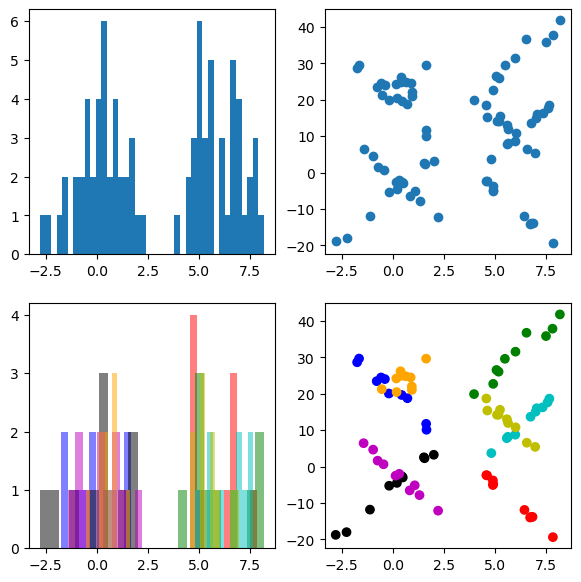

In [103]:
fig, ax = plt.subplots(2,2,figsize=(7,7))

ax[0,0].hist(Xs,bins=40)
ax[0,1].scatter(Xs,Ys)

for i in np.unique(inds):
    ax[1,0].hist(Xs[np.where(inds==i)],
                 color=col_map[i],alpha=0.5)

ax[1,1].scatter(Xs,Ys,c=[col_map[i] for i in inds])
plt.show()

# Run Gibbs Sampler

In [104]:
Xs = Xs[random_perm].reshape(-1,1)
Ys = Ys[random_perm]
Zs = Xs[random_perm]

Xs = np.hstack([np.ones(len(Xs)).reshape(-1,1),Xs])

In [105]:
import time

In [106]:
np.random.seed(1)

In [107]:
len(Ys)

80

In [108]:
#%%prun -T report.txt

start_time = time.time()

# Dist mat
tau = 0.5
lambda_matrix = pairwise_distances(X=Zs.reshape(-1,1), metric=exp_sim_func, tau=tau)

# intialize 
names_used = [1,2,3]
alpha_samp = 1
partition_samp = np.random.choice(names_used,len(Xs))


delta_samp = 0
sim_mat = lambda_matrix
order_samp = np.arange(len(Ys))
np.random.shuffle(order_samp)
phi_samp = np.array([[0.5,0.5],
                     [2,2],
                     [-1,-1]])

#### gibbs sampling hyper parameters
n_gibbs = 100
n_burn_in = 0
k = 150 # no. of numbers to permute order
n_chain = 2

# GRW sampler param
rw_sd = 0.2

# alpha prior
a_alpha = 1
b_alpha = 10
alpha_bounds = [0,1e99]

# delta prior
a_delta = 1
b_delta = 1
w = 0.5
delta_bounds = [0,1]

# phi / regression prior
phi_mean_prior = np.array([0,0])
phi_cov_prior = np.array([[1,0],[0,1]])
sigma_reg = 1

partition_init = partition_samp

phi_init = np.array([[0.5,0.5],
                     [2,2],
                     [-1,-1]])

labels_used = [1,2,3]

In [109]:
import time

In [110]:
start_time = time.time()

gibbs_args = {'Ys':Ys,
            'Xs':Xs,
            'Zs':Zs,
            'sim_mat':lambda_matrix,
            'partition_init':partition_init,
            'phi_init':phi_init,
            'phi_mean_prior':phi_mean_prior,
            'phi_cov_prior':phi_cov_prior,
            'labels_used':labels_used,
            'alpha_init':0.5,
            'delta_init':0,
            'sigma_reg':1,
            'n_gibbs':n_gibbs,
            'n_burn_in':n_burn_in,
            'k':k,
            'a_alpha':a_alpha,
            'b_alpha':b_alpha,
            'a_delta':a_delta,
            'b_delta':b_delta,
            'w':0.5,
             'n_chain':1, 'opti':True}

mcmc_chain = gibbs_sample_regression(**gibbs_args)

end_time=time.time()

print("Time taken to run ",n_gibbs, " | ", (end_time-start_time)/60)

Gibbs:  0
Time taken to run  100  |  0.3433457811673482


In [86]:
len(pd.Series(mcmc_chain[1][-1]).unique())

60

In [70]:
Time taken to run  100  |  5.057649664084116

SyntaxError: invalid syntax (396861310.py, line 1)

In [46]:
2.60101277033488 * 1000

2601.0127703348803

In [48]:
2601/60

43.35

In [50]:
43/24

1.7916666666666667

# Calculating Similarity Matrix from MCMC samples

### By Chain

In [31]:
n_chains = 2

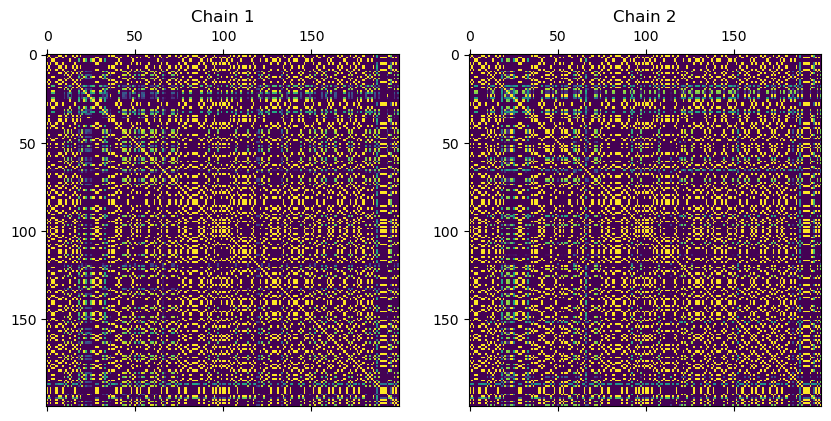

In [32]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
chk = []
for i in range(n_chains):
    
    partition_save = mcmc_chain[i][1]
    normalized_sim_mat = calc_hit_matrix(partition_save,
                                         burn_samples=0,
                                         normalize=True)
    chk.append(normalized_sim_mat)
    ax[i].matshow(normalized_sim_mat)
    ax[i].set_title(f'Chain {i+1}')

## Combined Chain

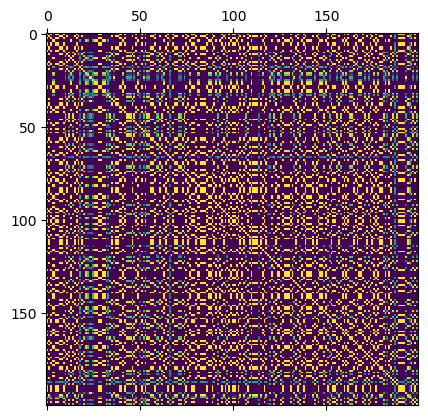

In [33]:
partition_save_combined = mcmc_chain[0][1] + mcmc_chain[1][1]

normalized_sim_mat = calc_hit_matrix(partition_save_combined,
                                     burn_samples=0,
                                     normalize=True)

plt.matshow(normalized_sim_mat)
plt.show()

In [34]:
sample_n_clusters = [len(np.unique(p)) for p in partition_save_combined]

In [35]:
agglo_cluster_solution = agglo_cluster(sim_matrix=normalized_sim_mat,
                                       n_clust=4,
                                       linkage_type='average')

In [36]:
pd.Series(agglo_cluster_solution).value_counts()

0    51
2    50
1    50
3    49
dtype: int64

In [37]:
col_map=['r', 'b', 'g','k','m','y','tab:orange']

In [38]:
inds = pd.Series(agglo_cluster_solution).value_counts().index

In [39]:
pd.Series(agglo_cluster_solution).value_counts().index

Int64Index([0, 2, 1, 3], dtype='int64')

In [40]:
inds

Int64Index([0, 2, 1, 3], dtype='int64')

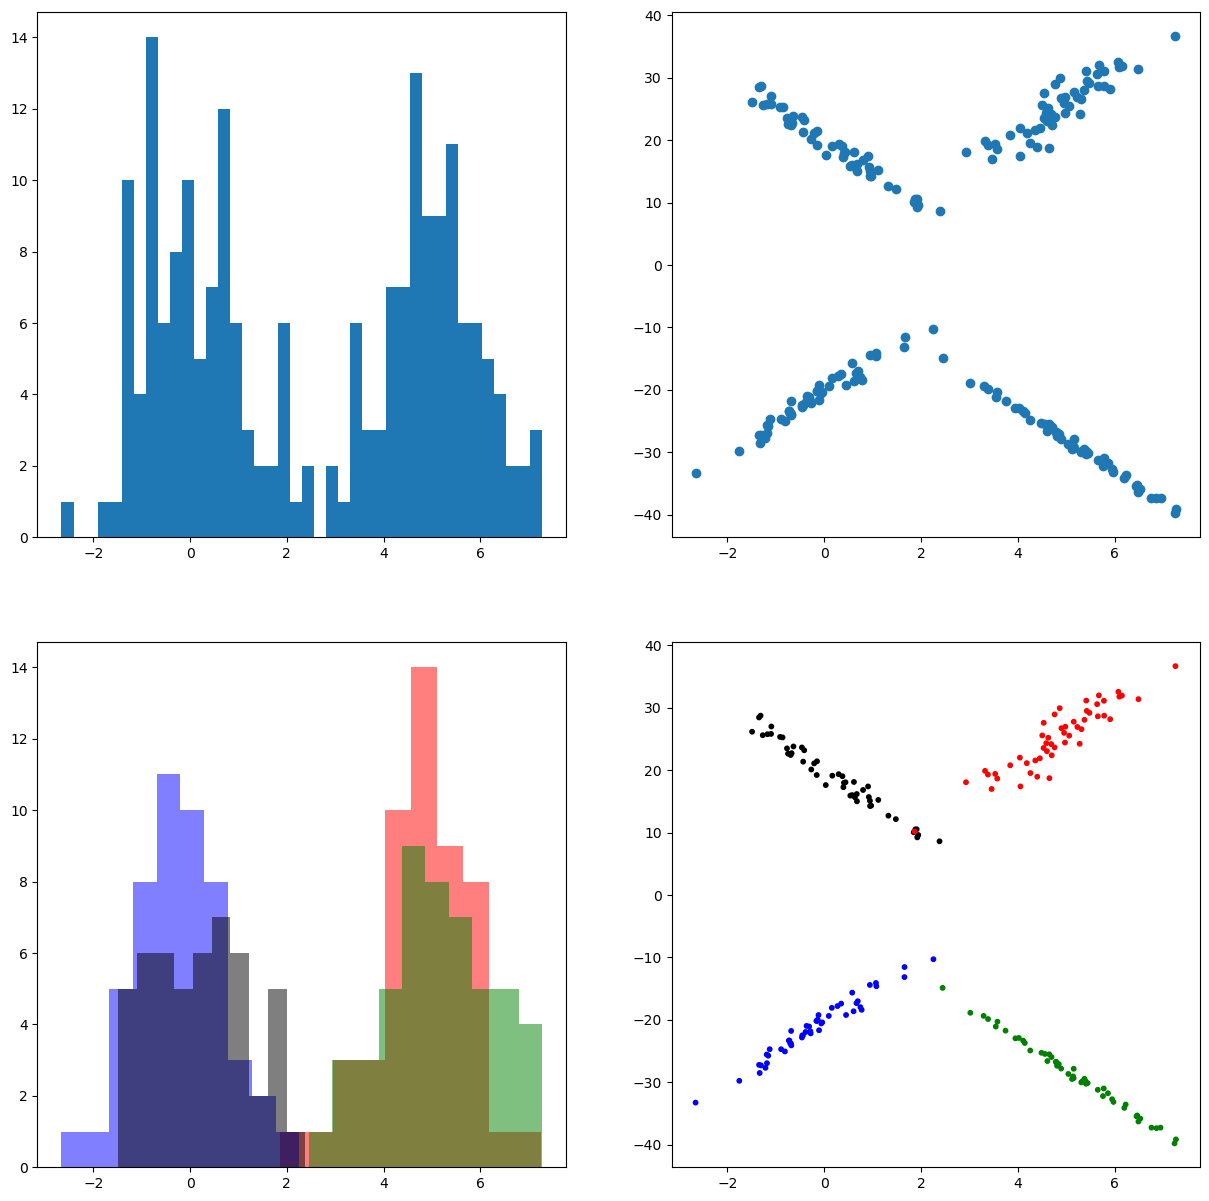

In [41]:
fig, ax = plt.subplots(2,2,figsize=(15,15))

ax[0,0].hist(Xs[:,1],bins=40)
ax[0,1].scatter(Xs[:,1],Ys)

for i in inds:
    ax[1,0].hist(Xs[:,1][np.where(agglo_cluster_solution==i)],
                 color=col_map[i],alpha=0.5)

ax[1,1].scatter(Xs[:,1],Ys,c=[col_map[i] for i in agglo_cluster_solution],s=10)
plt.show()

# MCMC Diagnostics

- How to diagnose convergence of clusterings?
- ARI between pairs

In [51]:
col_scheme = ['tab:blue','tab:orange','tab:red','tab:green']

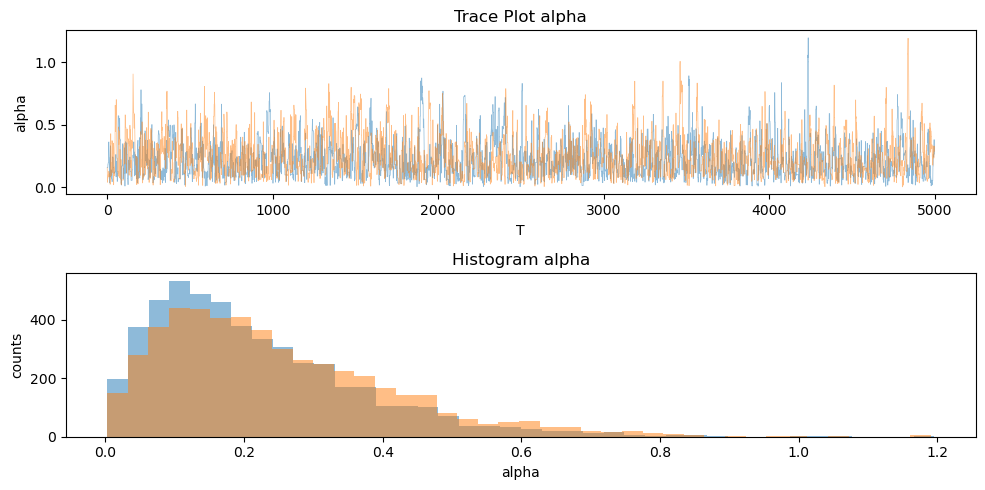

In [64]:
fig, ax = plt.subplots(2,1,figsize=(10,5))

for i in range(n_chain):

    ax[0].plot(mcmc_chain[i][2],c=col_scheme[i],alpha=0.5, lw=0.5)
    
ax[0].set_xlabel('T')
ax[0].set_ylabel('alpha')
ax[0].set_title('Trace Plot alpha')

for i in range(n_chain):
    
    ax[1].hist(mcmc_chain[i][2],color=col_scheme[i],alpha=0.5,bins=40)

ax[1].set_xlabel('alpha')
ax[1].set_ylabel('counts')
ax[1].set_title('Histogram alpha')
plt.tight_layout()
plt.show()


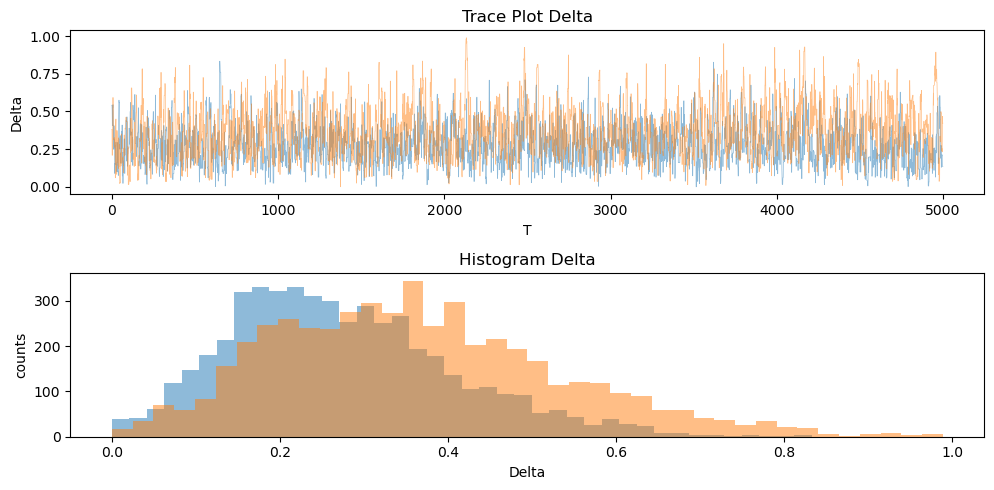

In [65]:
fig, ax = plt.subplots(2,1,figsize=(10,5))

for i in range(n_chain):

    ax[0].plot(mcmc_chain[i][3],c=col_scheme[i],alpha=0.5,lw=0.5)
    
ax[0].set_xlabel('T')
ax[0].set_ylabel('Delta')
ax[0].set_title('Trace Plot Delta')

for i in range(n_chain):
    
    ax[1].hist(mcmc_chain[i][3],color=col_scheme[i],alpha=0.5,bins=40)

ax[1].set_xlabel('Delta')
ax[1].set_ylabel('counts')
ax[1].set_title('Histogram Delta')
plt.tight_layout()
plt.show()

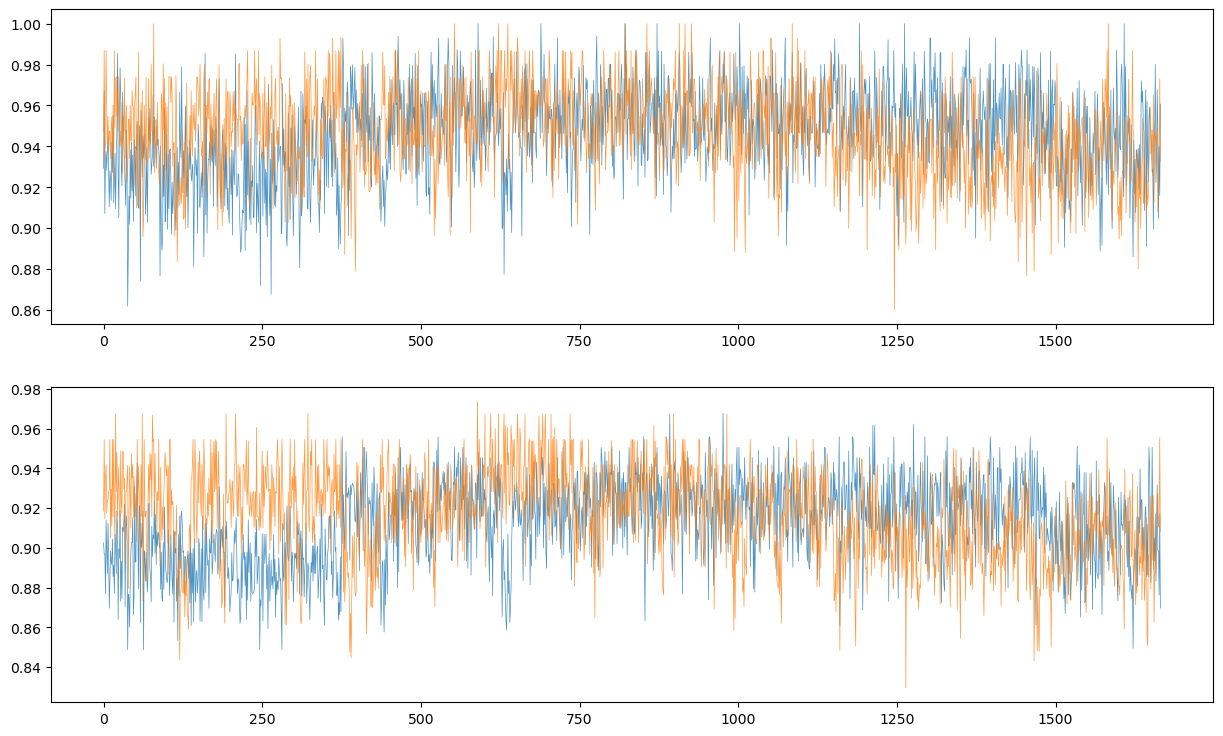

In [84]:
from sklearn.metrics import adjusted_rand_score
fig, ax = plt.subplots(2,1, figsize=(15,9))

for i in range(n_chains):
    
    ari_scores_within_samples_chain = []
    ari_scores_with_ext_clust_chain = []
    
    partition_save = mcmc_chain[i][1]
    
    for t in range(n_gibbs-2):

        ari_scores_within_samples_chain.append(adjusted_rand_score(partition_save[t],
                                              partition_save[t+1]))

        ari_scores_with_ext_clust_chain.append(adjusted_rand_score(partition_save[t],
                                          agglo_cluster_solution))
    
    

    ax[0].plot(ari_scores_within_samples_chain[0:len(ari_scores_within_samples_chain):3],
                                               lw=0.5, c=col_scheme[i],alpha=0.8)
    ax[1].plot(ari_scores_with_ext_clust_chain[0:len(ari_scores_within_samples_chain):3],
                                               lw=0.5, c=col_scheme[i],alpha=0.8)